In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from aams import AttentionNet, Encoder, Decoder

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.RandomCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(512, 512)),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize((_R_MEAN/255.0, _G_MEAN/255.0, _B_MEAN/255.0), (0.5, 0.5, 0.5))
    ]),
}

class FlatFolderDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        super(FlatFolderDataset, self).__init__()
        self.root = root
        self.paths = os.listdir(self.root)
        self.transform = transform

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        img = self.transform(img)
        return img

    def __len__(self):
        return len(self.paths)

    def name(self):
        return 'FlatFolderDataset'

train_set = FlatFolderDataset('../datasets/content_set/val2014', data_transforms['train'])
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=8,
    num_workers=2)
train_iter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


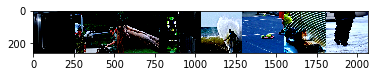

In [4]:

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images = dataiter.next()
print(images[0].size())
# show images
imshow(torchvision.utils.make_grid(images))


In [5]:
model = AttentionNet()
model.cuda()

AttentionNet(
  (encode): Encoder()
  (decode): Decoder(
    (deconv_4): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU()
      (7): ReflectionPad2d((1, 1, 1, 1))
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (9): ReLU()
      (10): ReflectionPad2d((1, 1, 1, 1))
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (12): ReLU()
    )
    (deconv_3): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode=nearest)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (6): ReLU()
    )
    (deconv_2): Sequential(
      (0

In [6]:
for input_batch in train_loader:
    input_batch = input_batch.to(device)
    print(input_batch.size())
    out = model.encode(input_batch)
    print(out['conv4'].size())
    recon =  model.decode(out['conv4'], out)
    print(recon.size())
    break

torch.Size([8, 3, 256, 256])
torch.Size([8, 512, 32, 32])
torch.Size([8, 3, 256, 256])


In [7]:
import argparse
import os
from tqdm import tqdm

In [ ]:
parser = argparse.ArgumentParser()
# Basic options
parser.add_argument('--content_dir', type=str, default='../train2014',
                    help='Directory path to a batch of content images')
parser.add_argument('--style_dir', type=str, default='./train',
                    help='Directory path to a batch of style images')
